# Example usage of the O-C tools

## This example shows how to construct and fit with MCMC the O-C diagram of the RR Lyrae star OGLE-BLG-RRLYR-02950

### We start with importing some libraries

In [1]:
import numpy as np
import oc_tools as octs

### We read in the data, set the period used to construct the O-C diagram (and to fold the light curve to construct the template curves, etc.), and the orders of the Fourier series we will fit to the light curve in the first and second iterations in the process

In [2]:
who    = "13534"
period = 0.463105
order1 = 10
order2 = 15

jd3, mag3 = np.loadtxt('data/{:s}.o3'.format(who), usecols=[0,1], unpack=True)
jd4, mag4 = np.loadtxt('data/{:s}.o4'.format(who), usecols=[0,1], unpack=True)

### We correct for possible average magnitude and amplitude differences between The OGLE-III and IV photometries by moving the intensity average of the former to the intensity average measured for the latter
### The variables "jd" and "mag" contain the merged timings and magnitudes of the OGLE-III + IV photometry, wich are used from hereon to calculate the O-C values

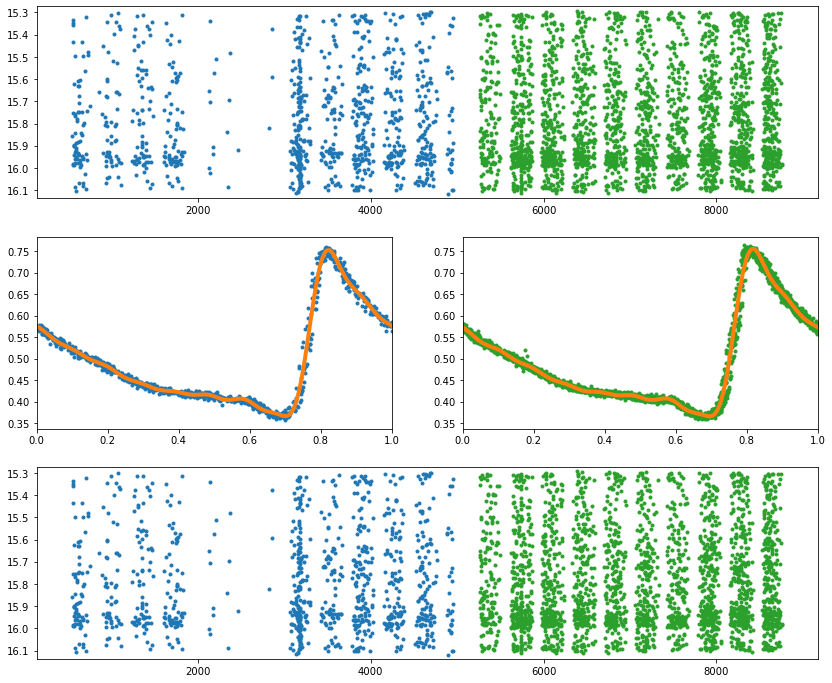

In [3]:
mag3_shift=octs.shift_int(jd3, mag3, jd4, mag4, order1, period, plot=True)
jd  = np.hstack((jd3,jd4))
mag = np.hstack((mag3_shift, mag4))

### Calling the split_lc_seasons() function provides us with an array containing masks splitting the combined light curve into short sections, depending on the number of points

### Optionally, the default splitting can be overriden by using the optional parameters "limits" and "into". For example, calling the function as:

octs.split_lc_seasons(jd, plot=True, mag = mag, limits = np.array((0, 8, np.inf)), into = np.array((0, 2)))
### will always split seasons with at least nine points into two separate segments

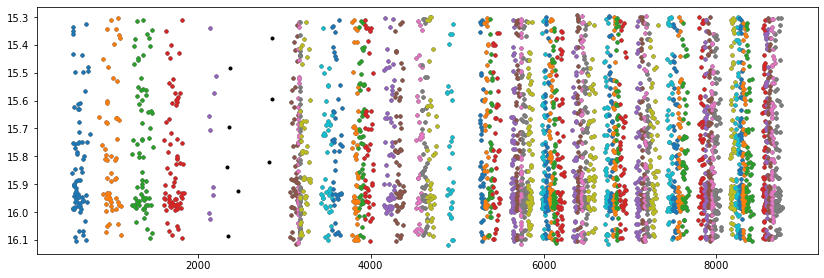

In [4]:
splits = octs.split_lc_seasons(jd, plot=True, mag = mag)#,
                               #limits = np.array((0, 8, 80, 120, 160, 240, np.inf)),
                               #into   = np.array((0, 1, 2,  3,   4,   5)))

### The function calc_oc_points() fits the light curve of the variable to produce a template, and uses it to determine the O-C points of the individual segments

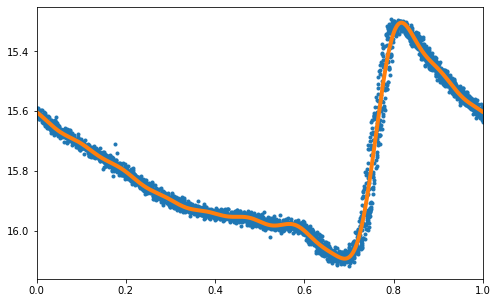

100%|██████████████████████████████████████████| 68/68 [00:00<00:00, 456.78it/s]


In [5]:
oc_jd, oc_oc = octs.calc_oc_points(jd, mag, period, order1, splits, figure=True)

### We make a guess at the binary parameters 

In [6]:
e      = 0.49
P_orb  = 3230.
T_peri = 7650.
a_sini = 0.0048
omega  = -np.pi
a= 7e-3
b= -3e-06
c= 2.5e-10
params = np.asarray((e, P_orb, T_peri, a_sini, omega, a, b, c))

lower_bounds = np.array((0.,     100., -np.inf, 0.0, -np.inf, -np.inf, -np.inf, -np.inf))
upper_bounds = np.array((0.99,  7000.,  np.inf, 1.0,  np.inf,  np.inf,  np.inf,  np.inf))

### We use the above guesses as the starting point (dashed grey line on the plot below) to find the O-C LTTE solution of the first iteration of our procedure. The yellow line on the plot shows the fit. The vertical blue bar shows the timing of the periastron passage

### Note that in this function also provides the timings of the individual observations corrected for this initial O-C solution

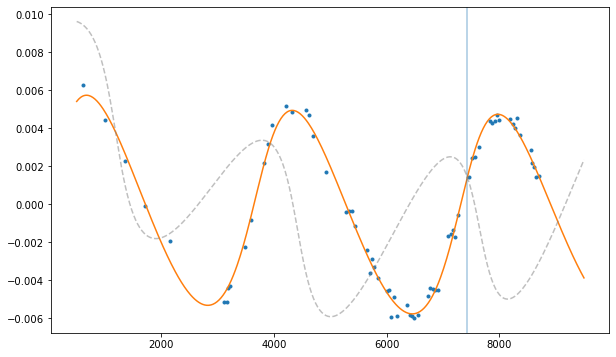

In [7]:
params2, jd2 = octs.fit_oc1(oc_jd, oc_oc, jd, params, lower_bounds, upper_bounds)

### We use the initial solution as the starting point for the MCMC fit, therefore we prepare it first by transforming $e$ and $\omega$ to $\sqrt{e}\sin{\omega}$ and $\sqrt{e}\sin{\omega}$
### For each parameter, we also have a lower and higher limit in its prior, but the values given for $\sqrt{e}\sin{\omega}$ and $\sqrt{e}\sin{\omega}$ are ignored, as these are handled separately within the function checking the priors

In [8]:
start      = np.zeros_like(params2)
start[0:3] = params2[1:4]
start[3]   = np.sqrt(params2[0]) * np.sin(params2[4])
start[4]   = np.sqrt(params2[0]) * np.cos(params2[4])
start[5:]  = params2[5:]

prior_ranges = np.asanyarray([[start[0]*0.9,         start[0]*1.1],
                              [start[1]-start[0]/4., start[1]+start[0]/4.],
                              [0.,                   0.057754266],
                              [0.,                   0.],
                              [0.,                   0.],
                              [-1.,                  1.],
                              [-1e-4,                1e-4],
                              [-1e-8,                1e-8]])

### We set a random seed to get reproducible results, then prepare the initial positions of the 200 walkers we are using during the fitting. During this, we check explicitly that these correspond to a position with a finite prior (i.e., they are not outside of the prior ranges defined above)

In [9]:
np.random.seed(0)
walkers = 200
random_scales = np.array((1e+1, 1e+1, 1e-4, 1e-2, 1e-2, 1e-3, 2e-7, 5e-11))
pos = np.zeros((walkers, start.size))

for i in range(walkers):
    pos[i,:]     = start + random_scales * np.random.normal(size=8)
    while np.isinf(octs.log_prior(pos[i,:], prior_ranges)):
        pos[i,:] = start + random_scales * np.random.normal(size=8)

### We recalculate the O-C points, but this time we use a higher-order Fourier series to fit the light curve with the modified timings, and we also calculate errors using bootstrapping

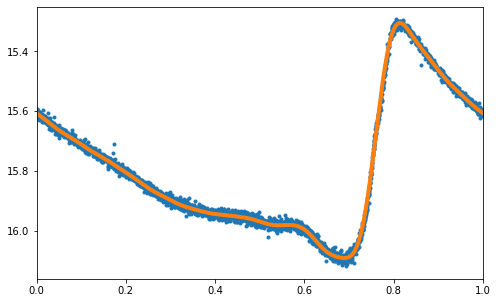

100%|███████████████████████████████████████████| 68/68 [01:16<00:00,  1.13s/it]


In [10]:
oc_jd, oc_oc, oc_sd = octs.calc_oc_points(jd, mag, period, order2, splits, 500, jd2, figure=True)

### We fit the O-C points measured above using MCMC by calling the run_mcmc() function
### We plot both the fit, as well as the triangle plot showing the two- (and one-)dimensional posterior distributions (these can be suppressed by setting the optional parameters "plot_oc" and "plot_triangle" to False)

100%|███████████████████████████████████| 20000/20000 [00:02<00:00, 7865.74it/s]


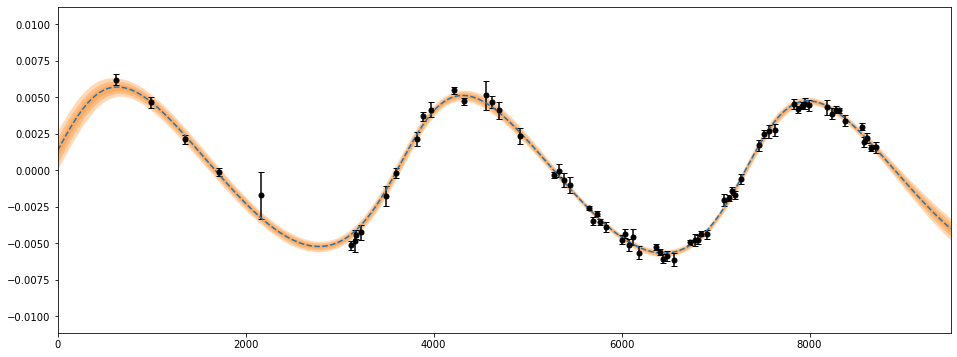

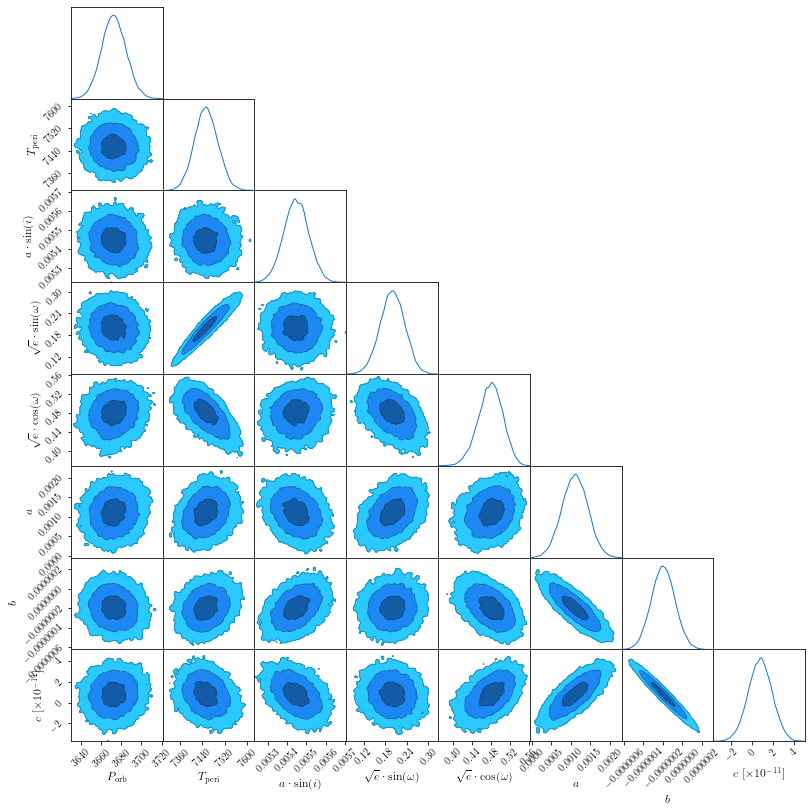

In [11]:
sampler, fit_mcmc, oc_sigmas, param_means, param_sigmas, fit_at_points, K =\
octs.run_mcmc(oc_jd, oc_oc, oc_sd,
              prior_ranges, pos,
              nsteps = 31000, discard = 1000,
              thin = 300, processes=1)

## The estimated LTTE parameters are:

In [12]:
print("Orbital period:             {:d} +- {:d}     [d]".format(int(param_means[0]),
                                                                int(param_sigmas[0])))
print("Projected semi-major axis: {:.3f} +- {:.3f} [AU]".format(param_means[2]*173.144633,
                                                                param_sigmas[2]*173.144633))
print("Eccentricity:              {:.3f} +- {:.3f}".format(param_means[3],
                                                           param_sigmas[3]))
print("Argumen of periastron:      {:+4d} +- {:d} [deg]".format(int(param_means[4]*180/np.pi),
                                                         int(param_sigmas[4]*180/np.pi)))
print("Periastron passage time:    {:d} +- {:d} [HJD-2450000]".format(int(param_means[1]),
                                                                      int(param_sigmas[1])))
print("Period-change rate:       {:+.3f} +- {:.3f} [d/Myr] ".format(param_means[7]*365.2422*2e6*period,
                                                                    param_sigmas[7]*365.2422*2e6*period))
print("RV semi-amplitude:         {:5.2f} +- {:.2f}  [km/s]".format(K[0], K[1]))
print("Mass function:           {:.5f} +- {:.5f} [M_Sun]".format(K[2], K[3]))

Orbital period:             3672 +- 12     [d]
Projected semi-major axis: 0.943 +- 0.011 [AU]
Eccentricity:              0.271 +- 0.022
Argumen of periastron:       +22 +- 4 [deg]
Periastron passage time:    7454 +- 41 [HJD-2450000]
Period-change rate:       +0.003 +- 0.004 [d/Myr] 
RV semi-amplitude:          2.90 +- 0.04  [km/s]
Mass function:           0.00830 +- 0.00031 [M_Sun]
